    Generatives adversarial networks (GANS)

In [1]:
# importing libraries
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [2]:
from utils import Logger

In [3]:
# obtengo el dataset MNIST
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [4]:
# Utilizo CUDA (GPU)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# discriminator 
class DiscriminatorNet(torch.nn.Module):
    """
    Red discriminativa de 3 capas ocultas
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [14]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [5]:
# Generador (Practicamente inverso al discriminador)
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [6]:
# Genera Ruido aleatorio
def noise(size):
    '''
    Ruido Gaussiano (100)
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [7]:
# Definimos los optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [8]:
# Definimos la función de coste
loss = nn.BCELoss().to(device)

In [9]:

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    data.to(device)
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    data.to(device)
    return data

In [10]:
# Entrenamiento del discriminador

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reiniciar los gradientes
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data.to(device))
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N).to(device) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data).to(device)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N).to(device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [11]:
def train_generator(optimizer, fake_data):
    fake_data.to(device)
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [12]:
num_test_samples = 16
test_noise = noise(num_test_samples)
print(device)
generator.to(device)
discriminator.to(device)


cuda


DiscriminatorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

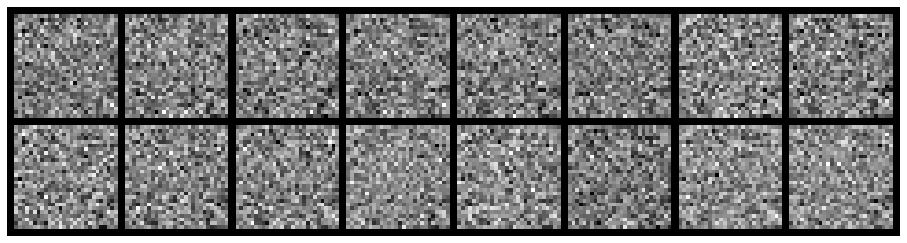

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.4097, Generator Loss: 0.7140
D(x): 0.4785, D(G(z)): 0.4894


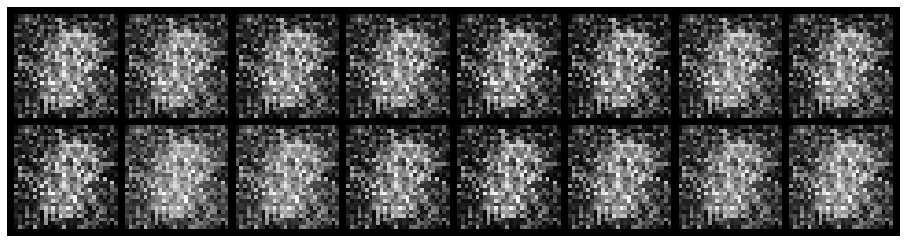

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 0.9032, Generator Loss: 2.8479
D(x): 0.6041, D(G(z)): 0.1852


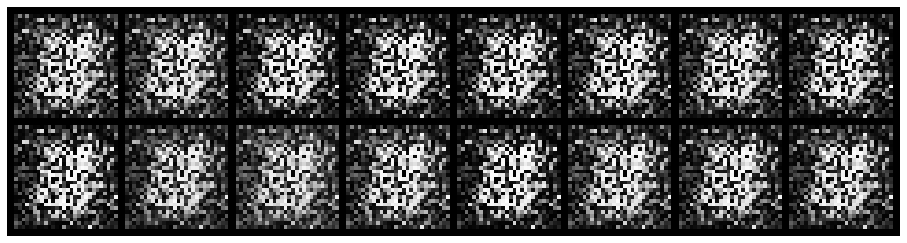

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 1.3299, Generator Loss: 2.2727
D(x): 0.7259, D(G(z)): 0.5417


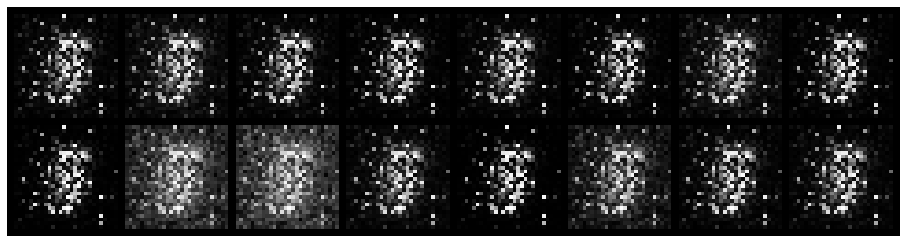

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 2.7008, Generator Loss: 0.9333
D(x): 0.4888, D(G(z)): 0.7477


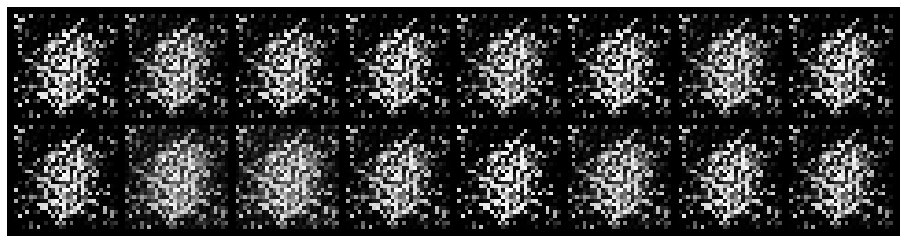

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.8782, Generator Loss: 1.7496
D(x): 0.9665, D(G(z)): 0.5337


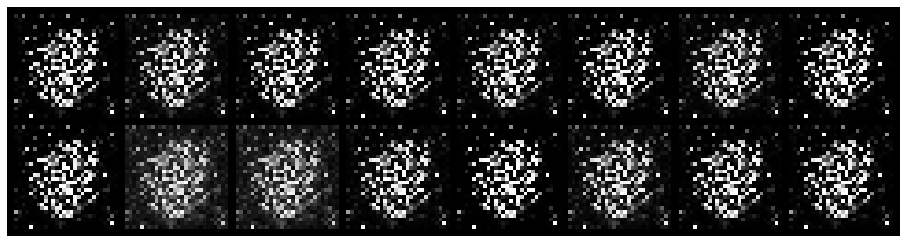

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.3170, Generator Loss: 4.3346
D(x): 0.9168, D(G(z)): 0.1550


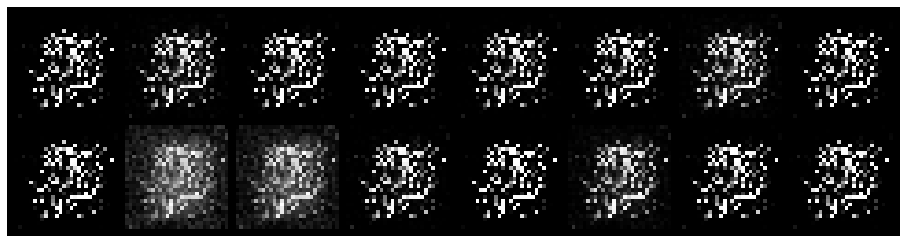

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.5821, Generator Loss: 2.9944
D(x): 0.7692, D(G(z)): 0.2062


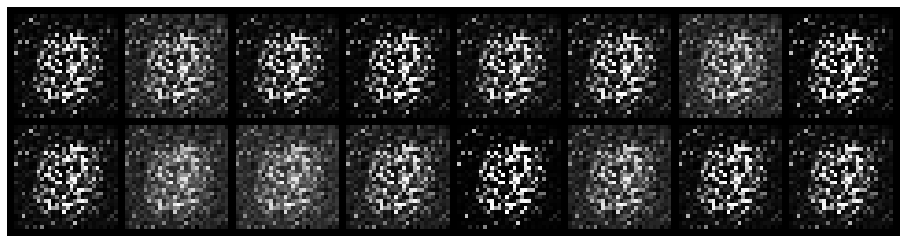

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.8648, Generator Loss: 1.9358
D(x): 0.7682, D(G(z)): 0.3873


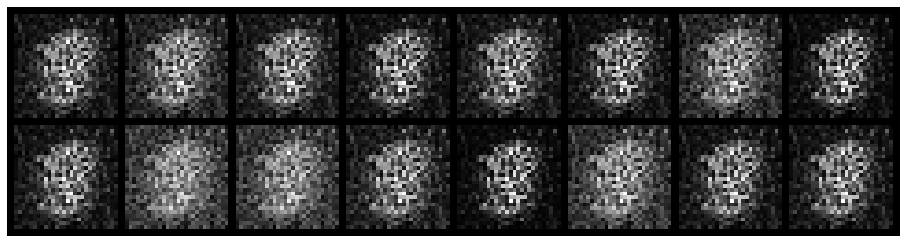

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.8945, Generator Loss: 2.3302
D(x): 0.8040, D(G(z)): 0.3452


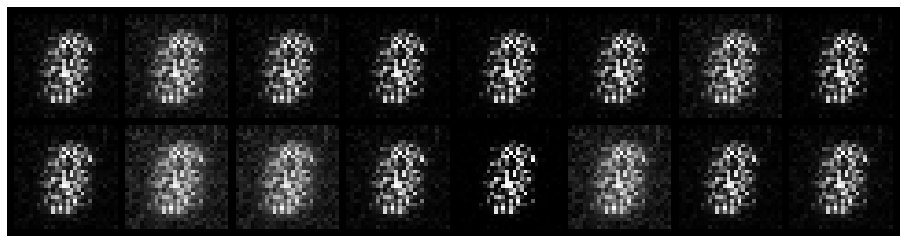

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.4099, Generator Loss: 3.2608
D(x): 0.8712, D(G(z)): 0.1810


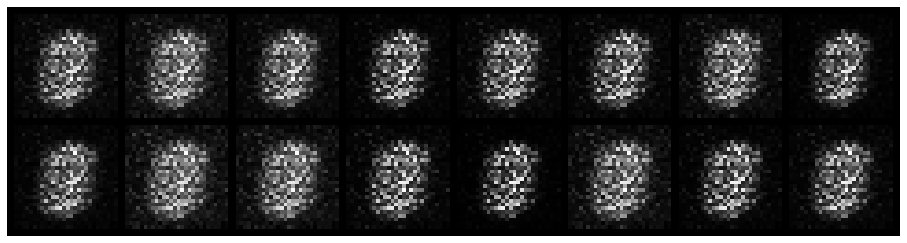

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.7222, Generator Loss: 2.7296
D(x): 0.7344, D(G(z)): 0.2405


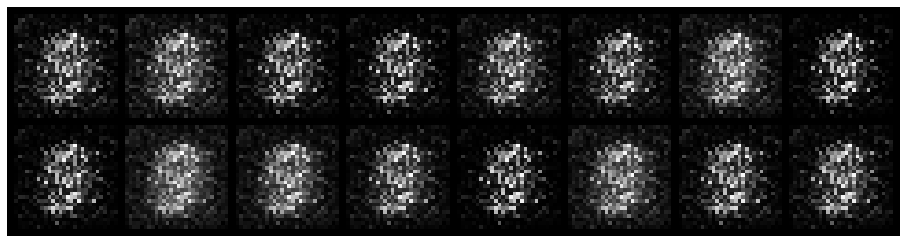

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 1.2899, Generator Loss: 1.2931
D(x): 0.6881, D(G(z)): 0.4799


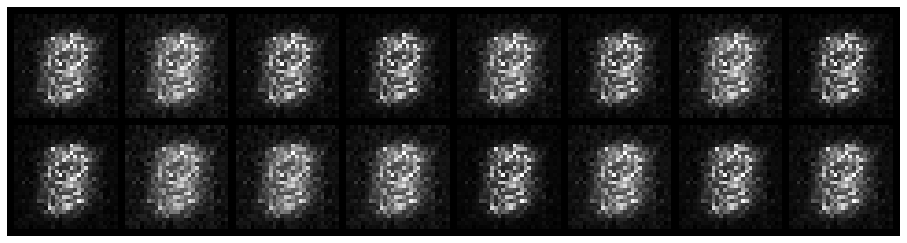

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.9378, Generator Loss: 1.1699
D(x): 0.7111, D(G(z)): 0.3908


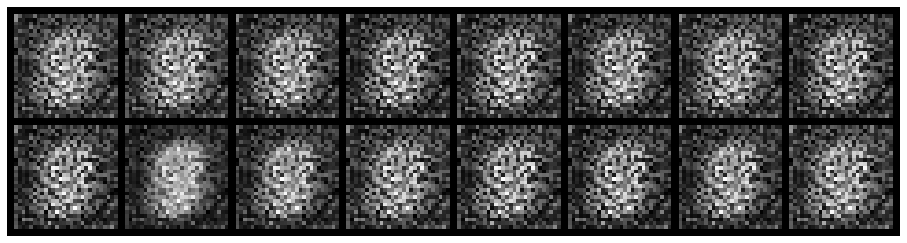

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.8195, Generator Loss: 1.6211
D(x): 0.7815, D(G(z)): 0.3585


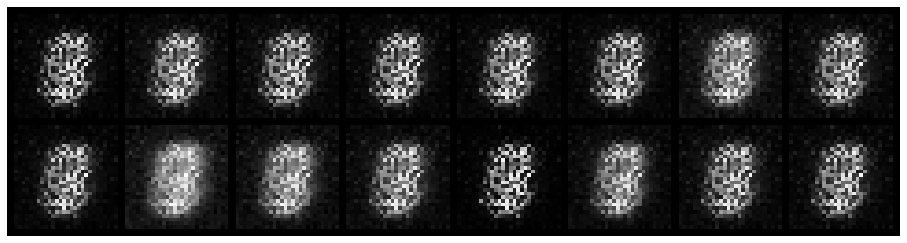

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 1.3029, Generator Loss: 1.5526
D(x): 0.5133, D(G(z)): 0.3327


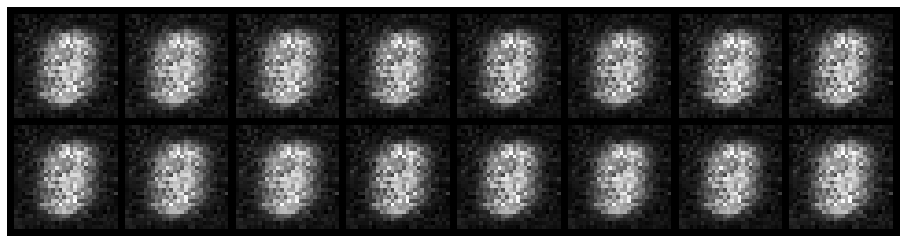

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 1.2857, Generator Loss: 0.8507
D(x): 0.6918, D(G(z)): 0.5491


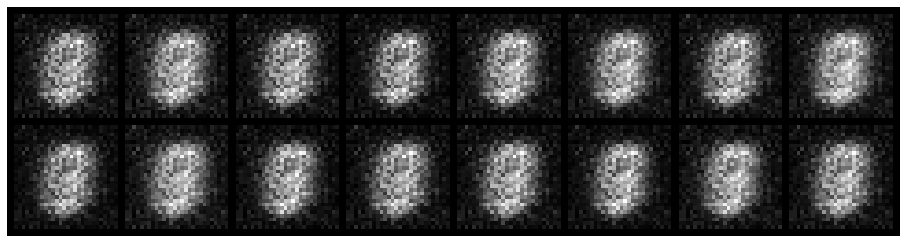

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 1.2263, Generator Loss: 4.7110
D(x): 0.7669, D(G(z)): 0.3500


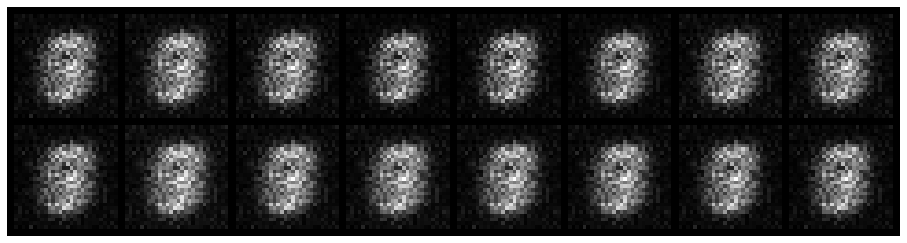

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 1.4501, Generator Loss: 1.7903
D(x): 0.6078, D(G(z)): 0.3700


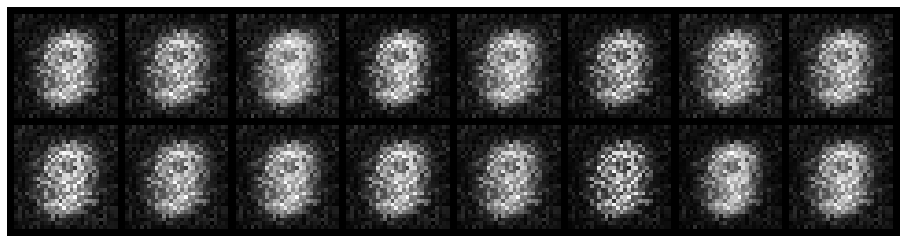

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 1.1887, Generator Loss: 2.0769
D(x): 0.6137, D(G(z)): 0.3682


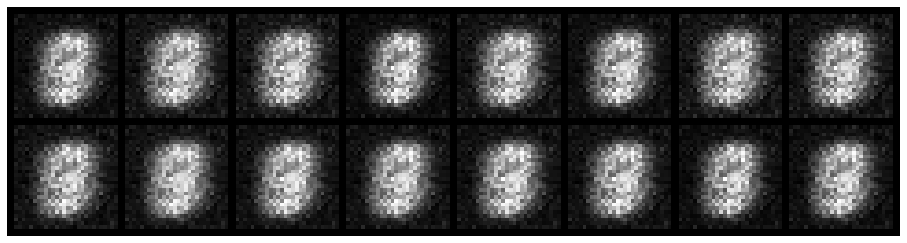

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 1.0921, Generator Loss: 1.1634
D(x): 0.7292, D(G(z)): 0.4763


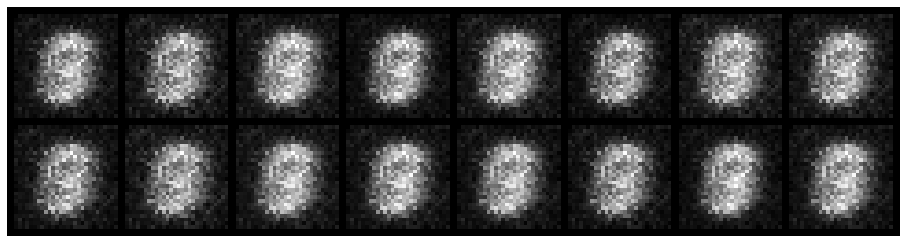

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.5237, Generator Loss: 2.1594
D(x): 0.8141, D(G(z)): 0.2216


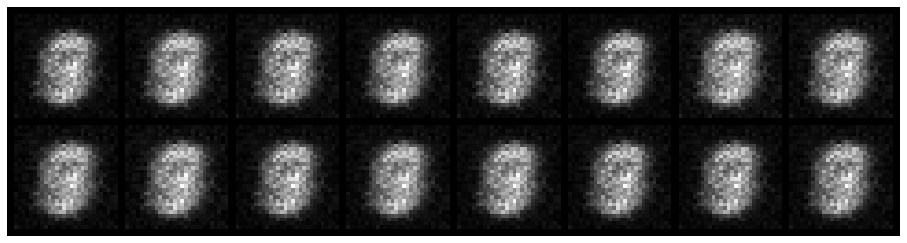

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.5137, Generator Loss: 1.8450
D(x): 0.8272, D(G(z)): 0.2368


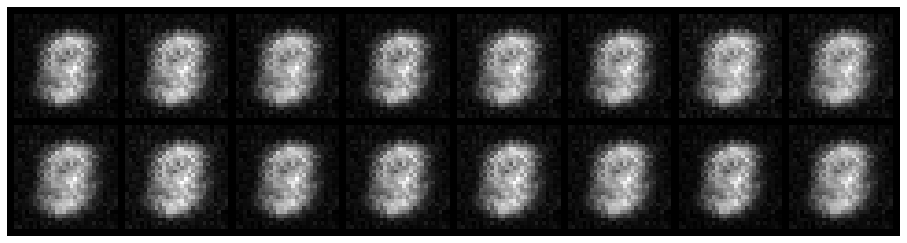

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.7896, Generator Loss: 1.3303
D(x): 0.7273, D(G(z)): 0.3228


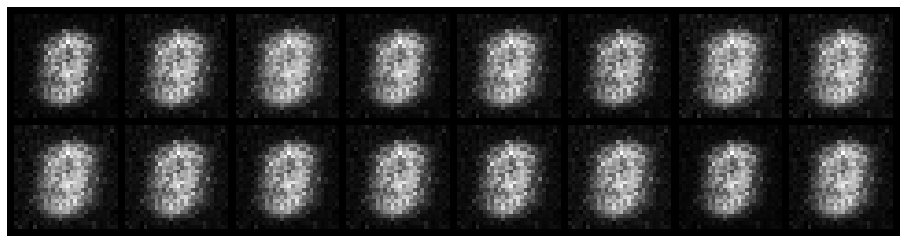

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 2.1079, Generator Loss: 1.1763
D(x): 0.4410, D(G(z)): 0.4776


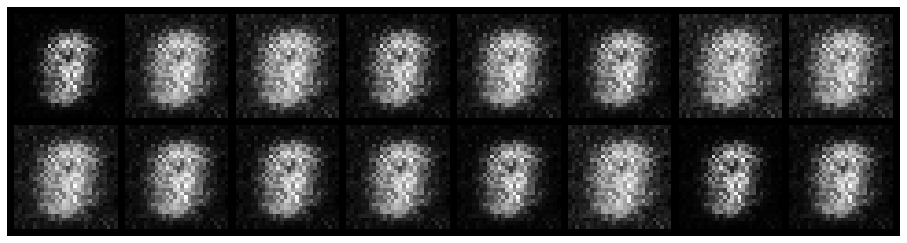

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.4158, Generator Loss: 2.9112
D(x): 0.8028, D(G(z)): 0.1244


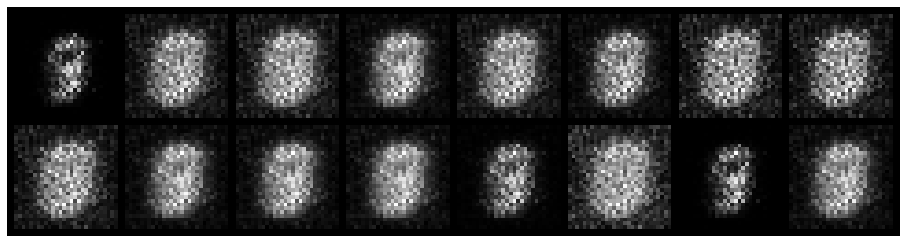

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.4729, Generator Loss: 3.7108
D(x): 0.8100, D(G(z)): 0.1262


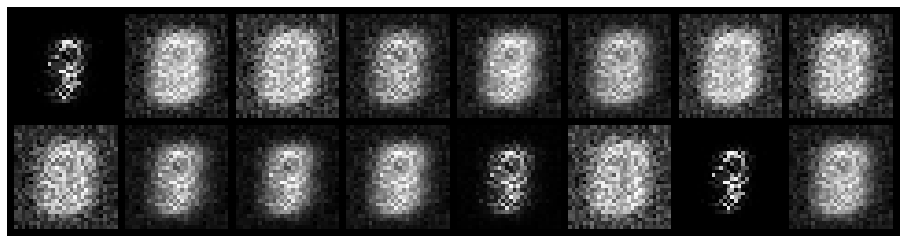

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.5499, Generator Loss: 2.9689
D(x): 0.8601, D(G(z)): 0.2068


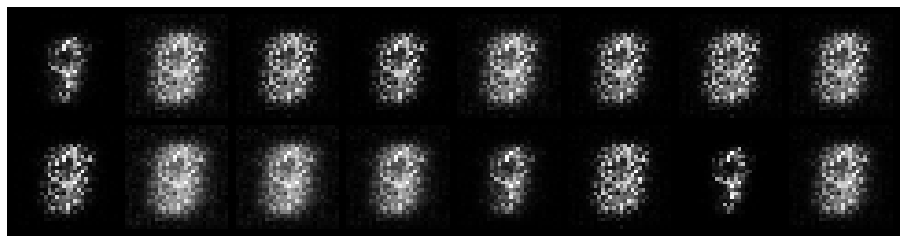

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.7407, Generator Loss: 2.3952
D(x): 0.7701, D(G(z)): 0.2413


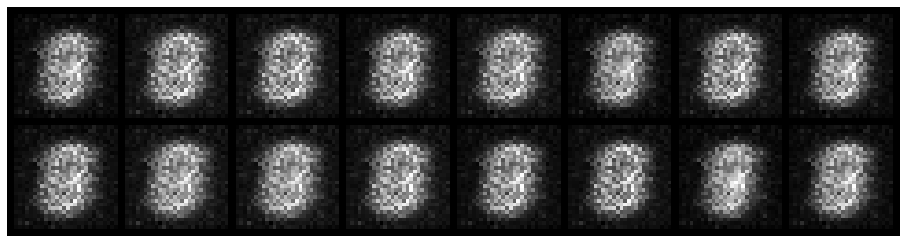

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.8747, Generator Loss: 1.5159
D(x): 0.7623, D(G(z)): 0.3021


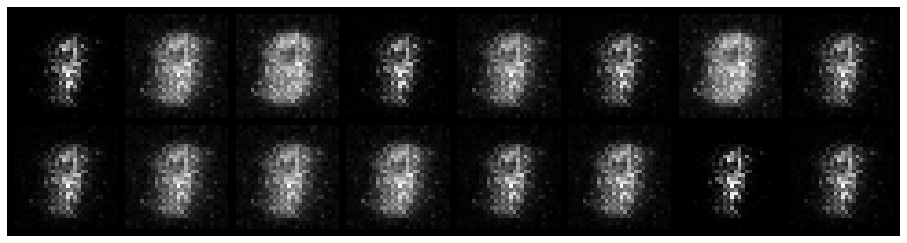

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.5295, Generator Loss: 2.0445
D(x): 0.8464, D(G(z)): 0.1840


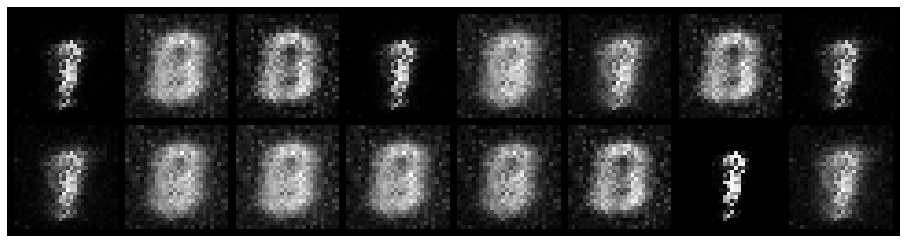

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.8012, Generator Loss: 2.0662
D(x): 0.8040, D(G(z)): 0.2775


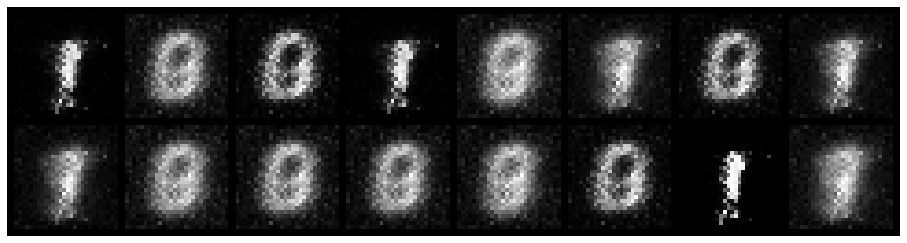

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.7099, Generator Loss: 2.2875
D(x): 0.8236, D(G(z)): 0.2270


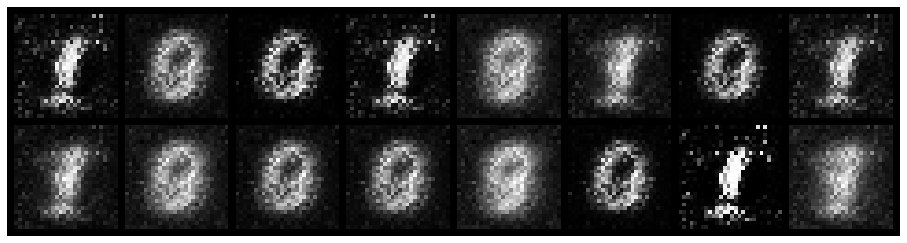

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.5045, Generator Loss: 3.2710
D(x): 0.8960, D(G(z)): 0.1156


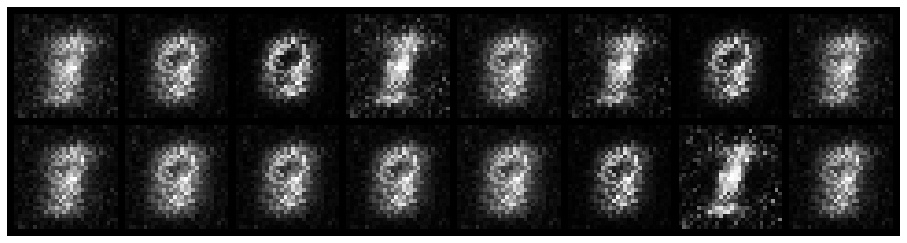

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.2184, Generator Loss: 5.2734
D(x): 0.9170, D(G(z)): 0.0240


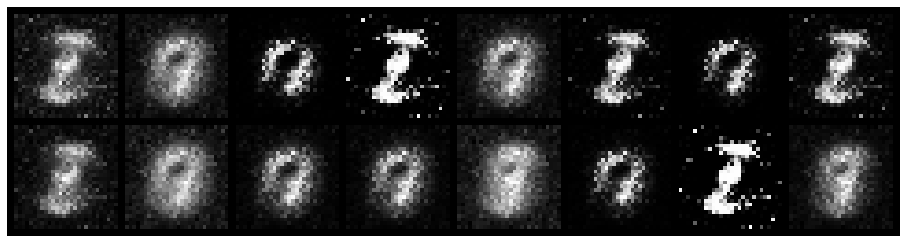

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.5008, Generator Loss: 2.8738
D(x): 0.8643, D(G(z)): 0.1903


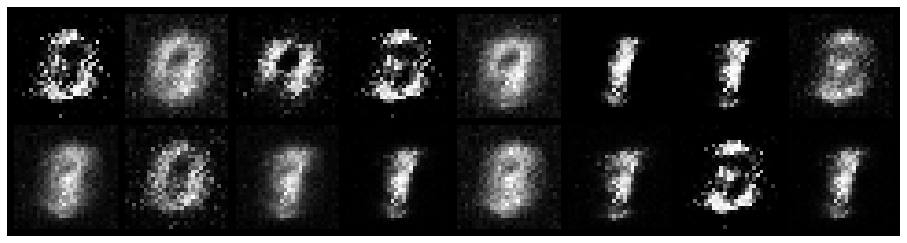

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.7386, Generator Loss: 2.3813
D(x): 0.8168, D(G(z)): 0.2748


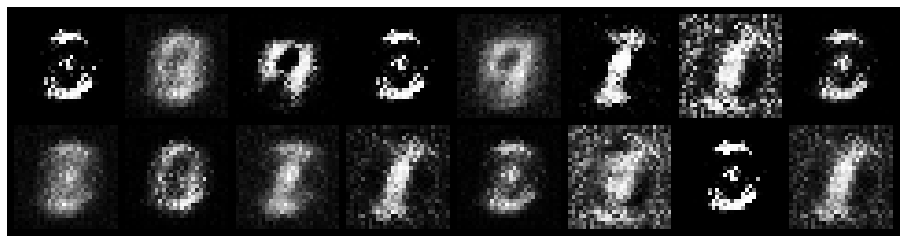

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.3847, Generator Loss: 2.5715
D(x): 0.9077, D(G(z)): 0.1903


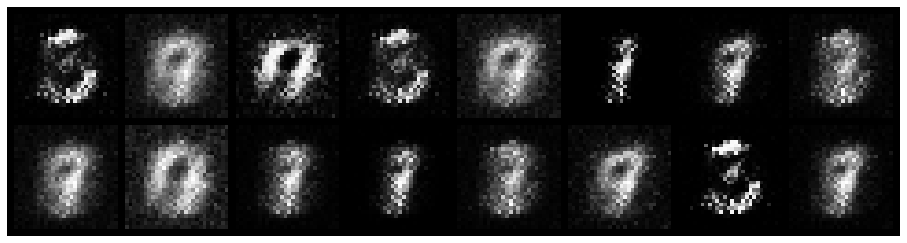

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.7487, Generator Loss: 2.8914
D(x): 0.8630, D(G(z)): 0.2481


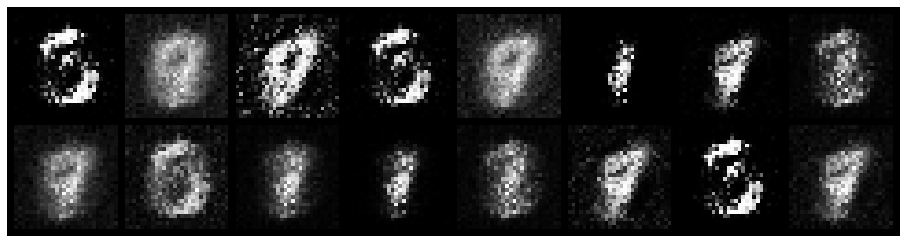

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.7657, Generator Loss: 2.7380
D(x): 0.7927, D(G(z)): 0.1856


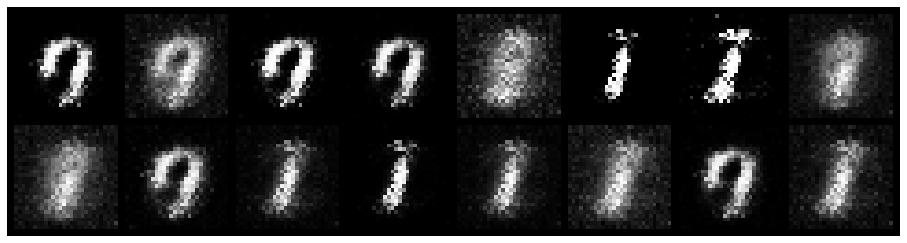

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.3906, Generator Loss: 3.0903
D(x): 0.9066, D(G(z)): 0.1368


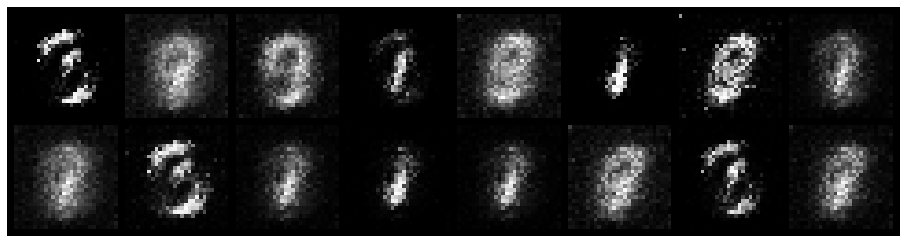

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.3752, Generator Loss: 2.2524
D(x): 0.9215, D(G(z)): 0.2005


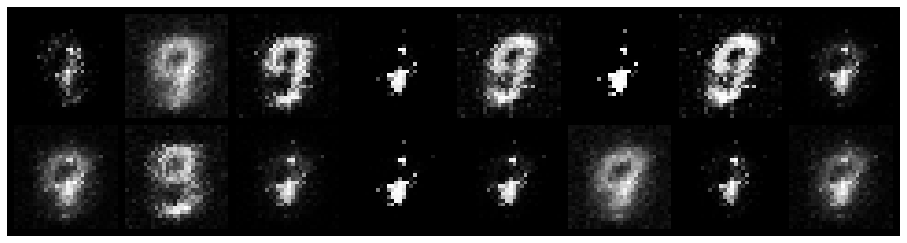

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.6320, Generator Loss: 2.3619
D(x): 0.8110, D(G(z)): 0.1764


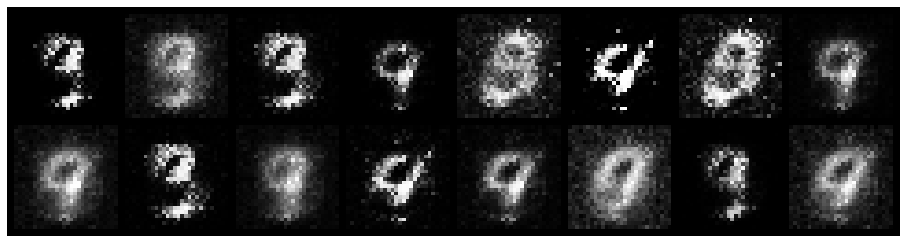

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.6652, Generator Loss: 1.8464
D(x): 0.8411, D(G(z)): 0.2406


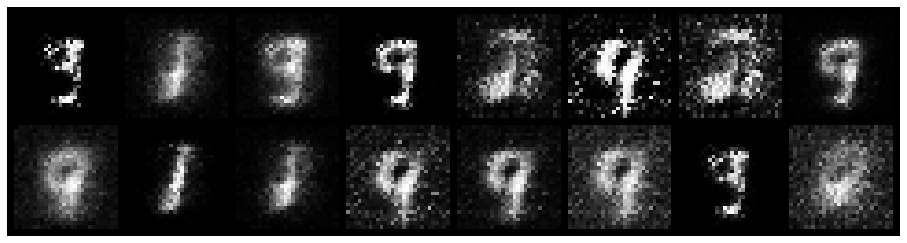

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.5324, Generator Loss: 2.6432
D(x): 0.8456, D(G(z)): 0.1446


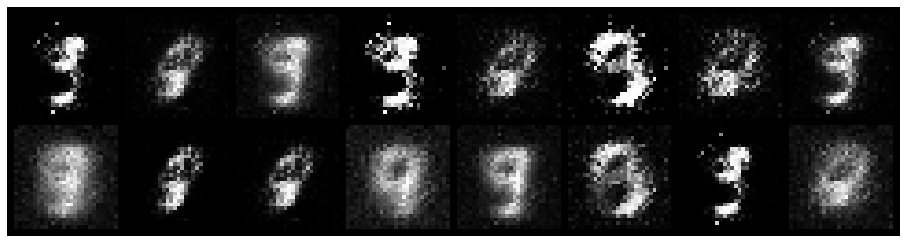

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.5070, Generator Loss: 2.6511
D(x): 0.8197, D(G(z)): 0.1308


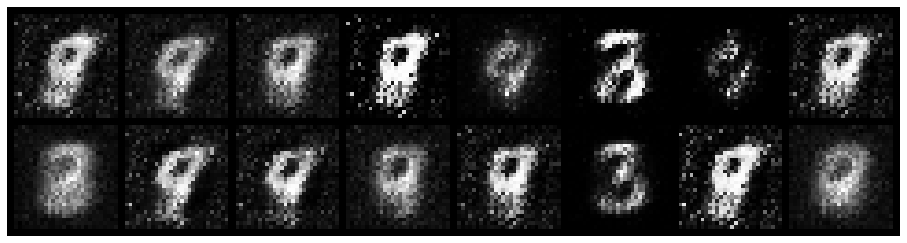

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.5692, Generator Loss: 2.0032
D(x): 0.8065, D(G(z)): 0.1989


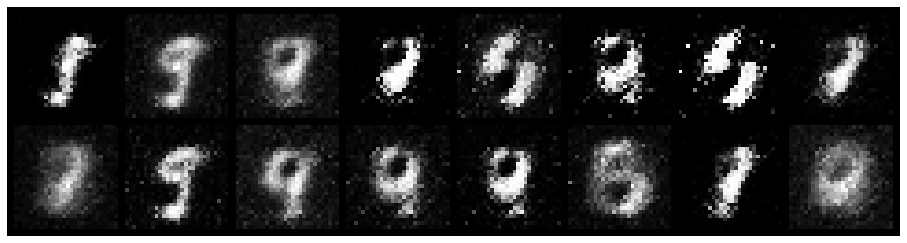

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.8662, Generator Loss: 2.0861
D(x): 0.6855, D(G(z)): 0.2234


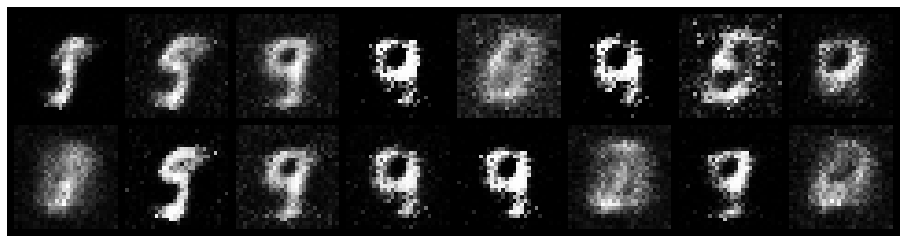

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.5688, Generator Loss: 1.9457
D(x): 0.8684, D(G(z)): 0.2314


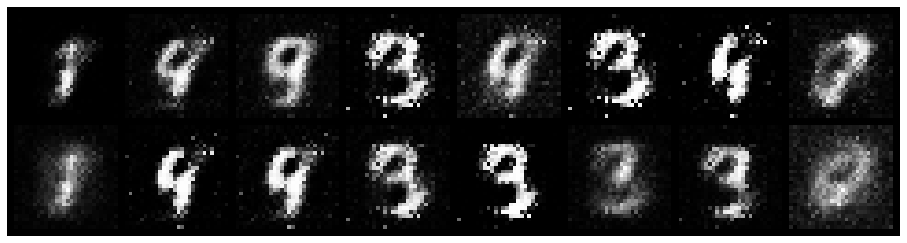

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.7708, Generator Loss: 1.8659
D(x): 0.7871, D(G(z)): 0.2437


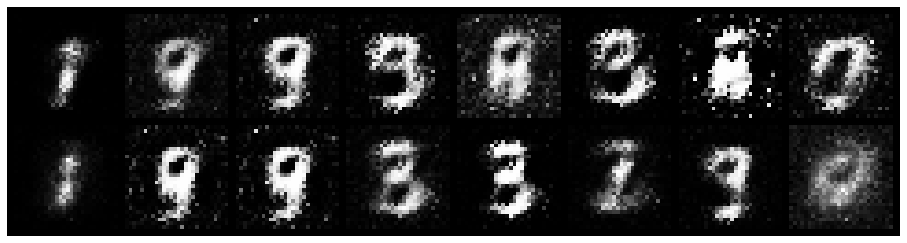

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.9460, Generator Loss: 1.8156
D(x): 0.6914, D(G(z)): 0.2347


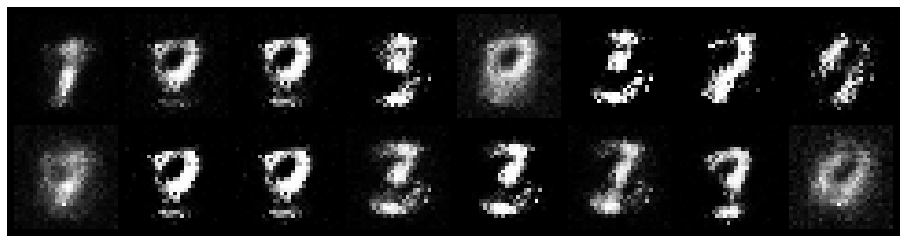

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 1.1434, Generator Loss: 1.7329
D(x): 0.6601, D(G(z)): 0.2763


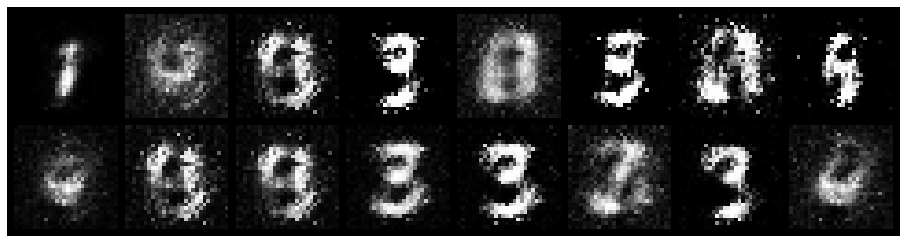

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.6073, Generator Loss: 2.7986
D(x): 0.7469, D(G(z)): 0.1013


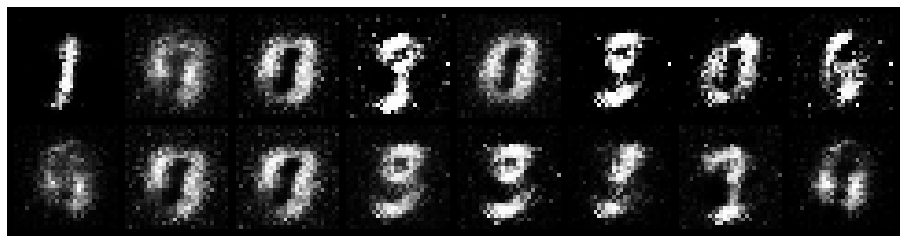

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.4757, Generator Loss: 2.7637
D(x): 0.8649, D(G(z)): 0.1528


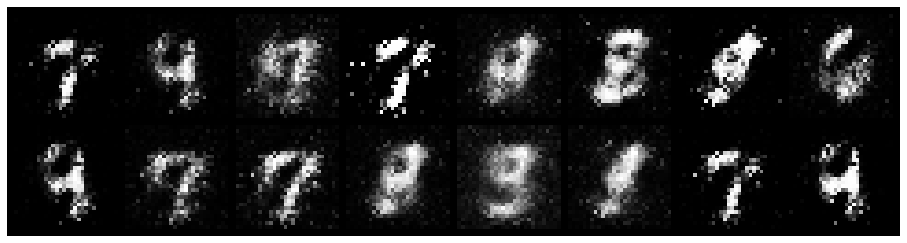

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.7887, Generator Loss: 1.9672
D(x): 0.7662, D(G(z)): 0.2155


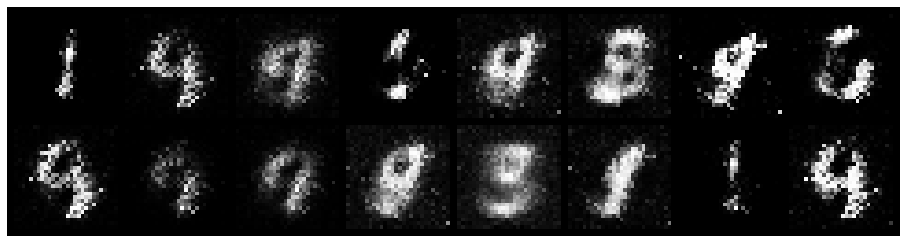

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.5880, Generator Loss: 1.6539
D(x): 0.7984, D(G(z)): 0.2136


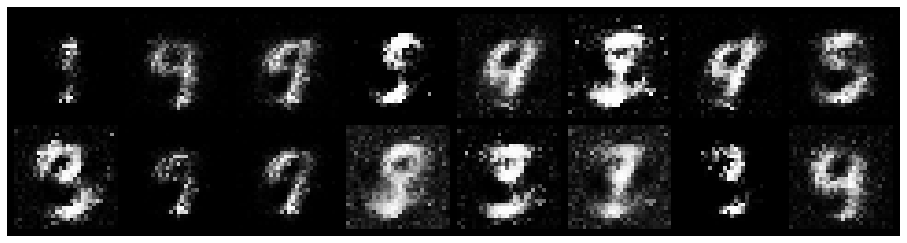

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.4618, Generator Loss: 3.5995
D(x): 0.8512, D(G(z)): 0.1055


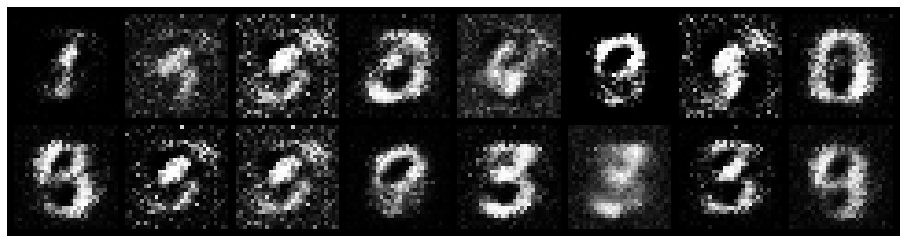

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.6810, Generator Loss: 2.3324
D(x): 0.7651, D(G(z)): 0.1482


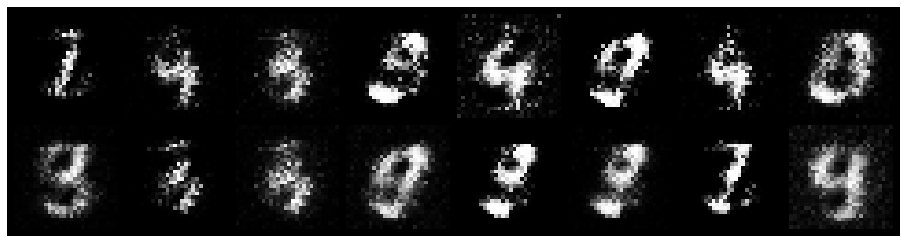

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.7965, Generator Loss: 1.4039
D(x): 0.8069, D(G(z)): 0.3439


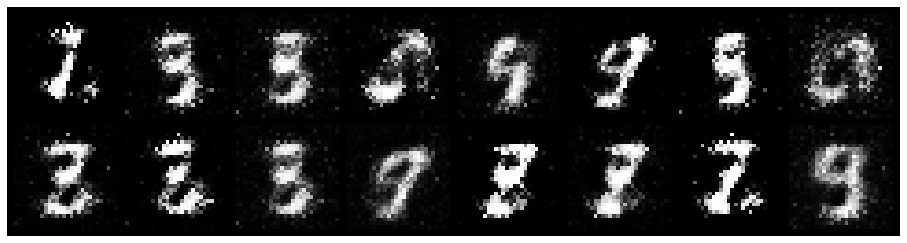

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.5658, Generator Loss: 2.9100
D(x): 0.8581, D(G(z)): 0.1933


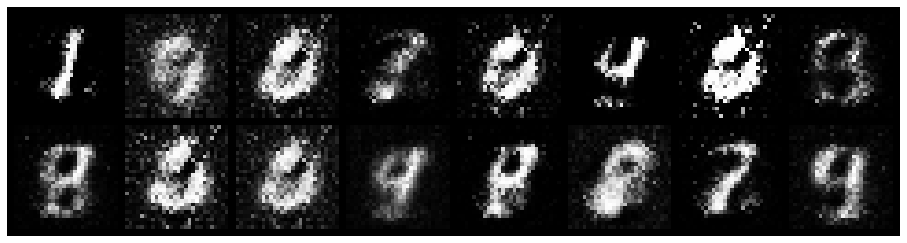

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.6929, Generator Loss: 2.2821
D(x): 0.7513, D(G(z)): 0.1436


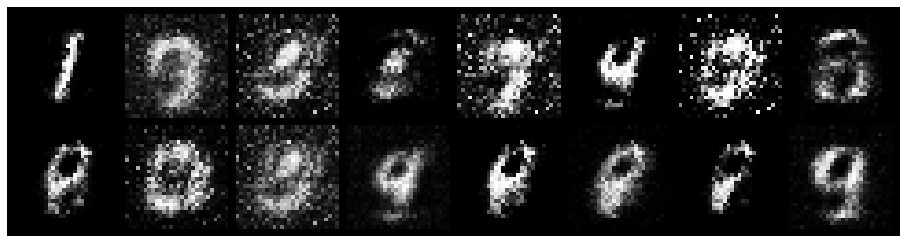

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.6290, Generator Loss: 3.0561
D(x): 0.7578, D(G(z)): 0.0949


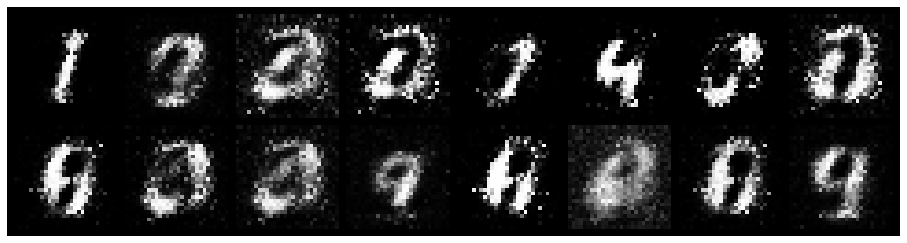

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.8969, Generator Loss: 2.2503
D(x): 0.6684, D(G(z)): 0.1917


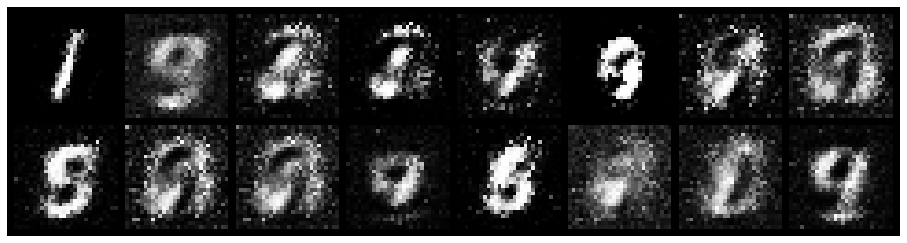

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 1.1099, Generator Loss: 1.3511
D(x): 0.7141, D(G(z)): 0.2867


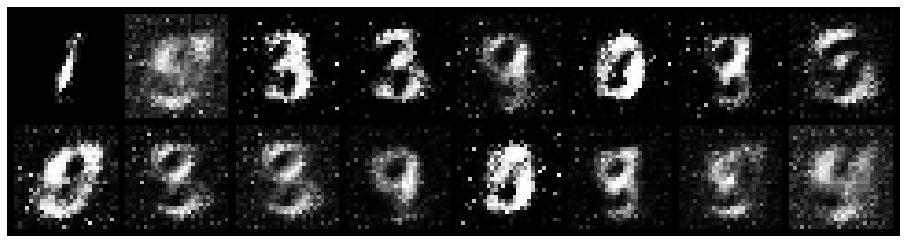

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 1.0073, Generator Loss: 2.3052
D(x): 0.7048, D(G(z)): 0.2220


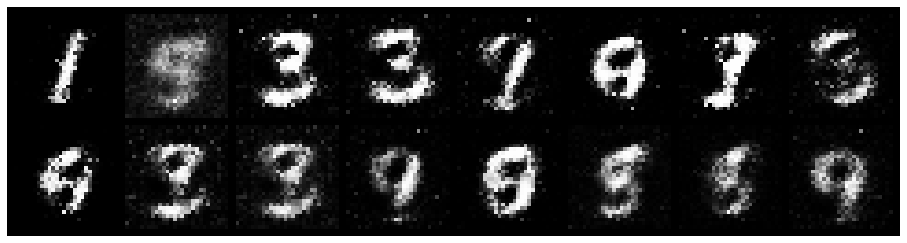

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.4385, Generator Loss: 3.0720
D(x): 0.8530, D(G(z)): 0.1497


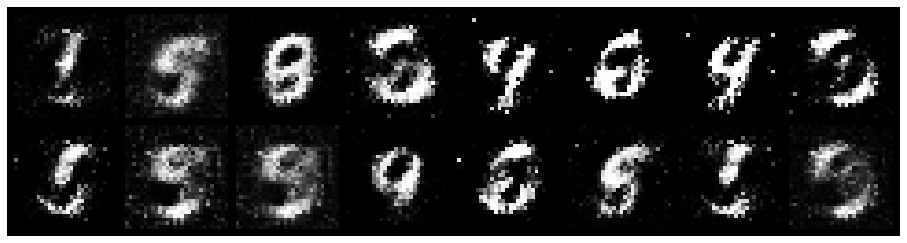

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.4580, Generator Loss: 2.2397
D(x): 0.8546, D(G(z)): 0.1711


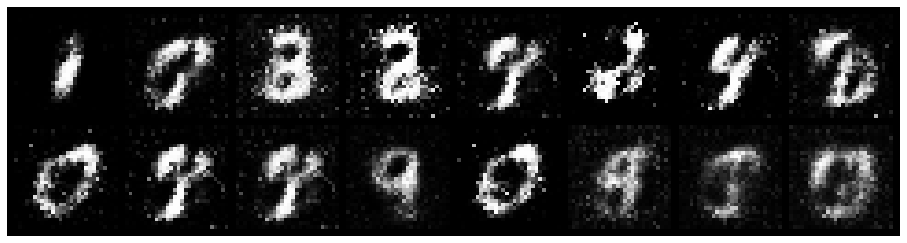

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.6927, Generator Loss: 2.5504
D(x): 0.8432, D(G(z)): 0.2531


In [ ]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N).to(device)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise.to(device)))
            test_images = test_images.data
            logger.log_images(
                test_images.to("cpu"), num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )